<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/mecanisticos-lote-alimentado/inhibition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# Importar modulos
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Método de Euler para resolver ODEs

In [142]:
def euler(f, x0, t0, tf, dt, u, *kargs):

    """
    Solve a system of differential equations using the Euler method.
    
    Parameters:
    f (function): The derivative function.
    x0 (ndarray): The initial state.
    t0 (float): The initial time.
    tf (float): The final time.
    dt (float): The time step.
    u (function): The input function.
    
    Returns:
    ndarray: The state at each time step.
    """
    t = np.arange(t0, tf, dt)
    x = np.zeros((len(t), len(x0)))
    x[0, :] = x0
    for i in range(1, len(t)):
        # print(x[i,:])
        x[i, :] = x[i-1, :] + dt * f(x[i-1, :], t[i-1], u(t[i-1]), *kargs)
    return x


In [143]:
# Funcion de ejemplo para definir la derivada
def f(x, t, u, k, m):
    """
    The derivative function for a simple state space model.
    
    Parameters:
    x (ndarray): The state.
    t (float): The time.
    u (float): The input.
    
    Returns:
    ndarray: The derivative of the state.
    """
    return np.array([k*x[1], u - m*x[0]])

In [144]:
# Funcion de ejemplo para definir el input
def u(t):
    """
    An example input function that changes over time.
    
    Parameters:
    t (float): The time.
    
    Returns:
    float: The input at time t.
    """
    return 2

In [145]:
# Set the initial state and time
x0 = np.array([0, 0])
t0 = 0

# Set the final time and time step
tf = 15
dt = 0.01
time = np.arange(0, tf, dt)
# Simulate the state space model using the Euler method
x = euler(f, x0, t0, tf, dt, u, 1, 1)

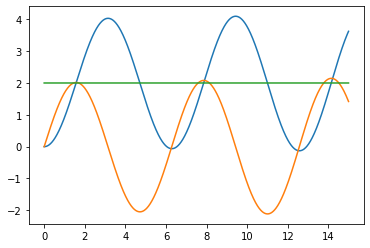

In [146]:
plt.plot(time, x)
plt.plot(time, [u(t) for t in time])
plt.show()

In [147]:
# Define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

In [148]:
# Define input temperature to the cstr
def input_temp(time):
    # (1.0, 10.0, 19.0)

    # 300.0
    # u[10:100] = 303.0
    # u[100:190] = 297.0
    # u[190:] = 300.0
    if time < 1.0:
        return u_ss
    elif time < 10:
        return 303.0
    elif time < 19:
        return 297
    else:
        return 300

In [149]:
# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

In [150]:
# Set the initial state and time
x0 = np.array([Ca_ss, T_ss])
t0 = 0

# Set the final time and time step
tf = 25
dt = 0.01
# Time Interval (min)
time = np.arange(0,tf,dt)

# Simulate the state space model using the Euler method
Ca, T = euler(cstr, x0, t0, tf, dt, input_temp, Tf, Caf).T

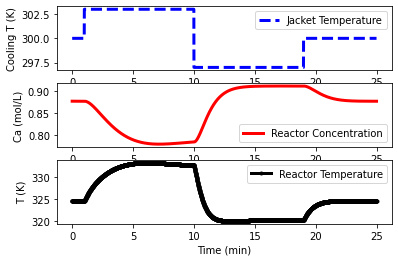

In [151]:
# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(time, [input_temp(t) for t in time],'b--',lw=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(time,Ca,'r-',lw=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(time,T,'k.-',lw=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.show()

In [152]:
# Definir modelo de inhibicion por sustrato
def inhibition_model(y, t, u, mu_max, yxs, ks, ypx, ki, sf):
                         # mu_max, yxs, ks, ypx, ki, sf
    F = u

    x, s, V = y

    # This is the part that will be sustituted by an ANN likely
    growth_rate = mu_max*(s/(ks+s+ki*s**2))

    # Mass balances 
    dx = growth_rate*x - F*x/V
    ds = F/V*(sf-s) -1/yxs*growth_rate*x
    dV = F
    # dp = ypx*growth_rate*x 

    return np.array([dx, ds, dV])

In [153]:
def inflow_rate(t):

    return 0

In [154]:
# Parameters
mu_max = 1.21
yxs = 0.2
ks = 280
ypx = 4
ki = 0.3
sf = 40

In [155]:
# Initial conditions
x0 = np.array([0.2, 40, 10])

# Integration time
tf = 100
dt = 1
time = np.arange(0, tf, dt)

# Solve the ODEs
x, s, V = euler(inhibition_model, x0, 0, tf, dt, inflow_rate, mu_max, yxs, ks, ypx, ki, sf).T

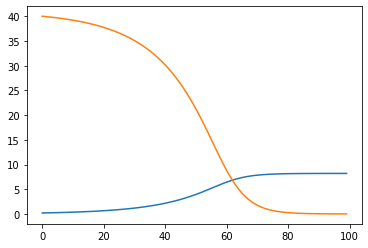

In [156]:
plt.plot(time, x)
plt.plot(time, s)

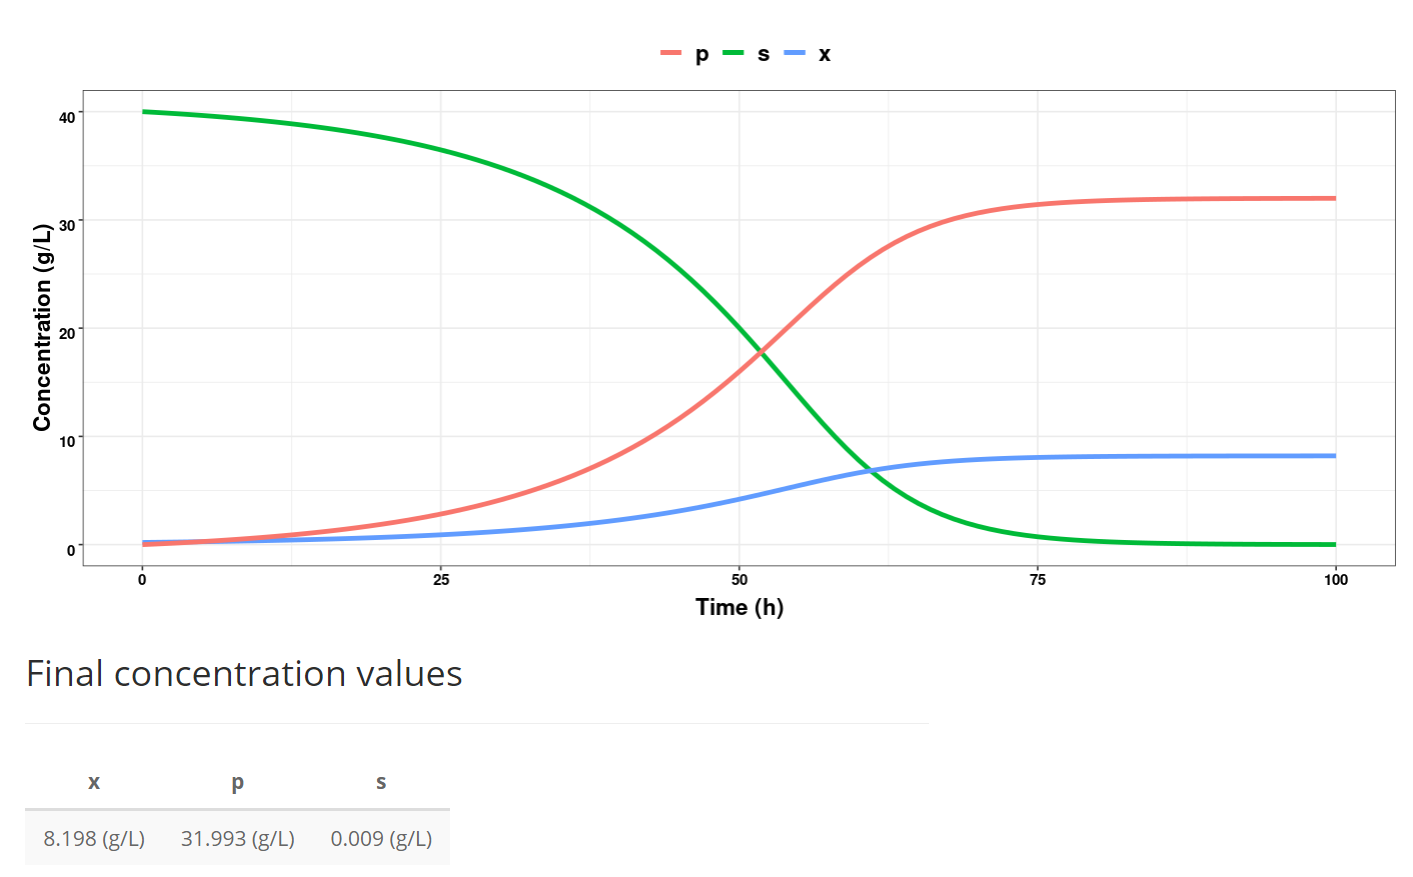

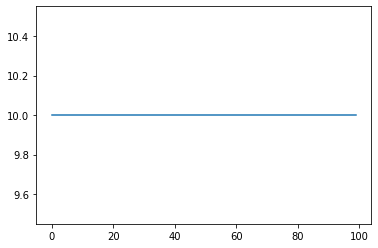

In [157]:
plt.plot(time, V)

In [158]:
y = odeint(inhibition_model, x0, time, args=(1, mu_max, yxs, ks, ypx, ki, sf))

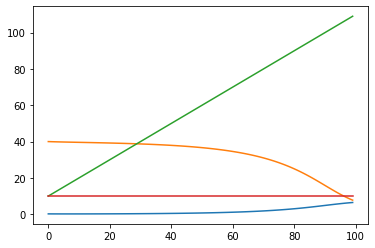

In [159]:
plt.plot(time, y)
plt.plot(time, V)

x	p	s

8.2 (g/L)	31.999 (g/L)	0.001 (g/L)